In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from scipy.stats import zscore

# Load Dataset
df = pd.read_csv("/diabetes_prediction_dataset.csv")


# **Handling Missing Values**

In [14]:
# Replace placeholders with NaN in HbA1c_level
df['HbA1c_level'] = pd.to_numeric(df['HbA1c_level'].replace(["???", "Unknown"], np.nan), errors='coerce')

# Fill missing values with grouped median imputation
df['HbA1c_level'] = df['HbA1c_level'].fillna(
    df.groupby(['gender', 'diabetes'])['HbA1c_level'].transform('median'))


## **Encoding Categorical Features**

In [15]:
# One-Hot Encoding for 'smoking_history'
df_encoded = pd.get_dummies(df, columns=['smoking_history'], drop_first=True)

# Convert 'gender' to numeric (Label Encoding: Male = 1, Female = 0)
df_encoded['gender'] = df_encoded['gender'].map({'Male': 1, 'Female': 0})

# Fill missing gender values with the most frequent value
df_encoded['gender'] = df_encoded['gender'].fillna(df_encoded['gender'].mode()[0])

## **Scaling Numerical Features**

In [16]:
# Feature Scaling
minmax_features = ["bmi", "HbA1c_level", "blood_glucose_level"]
standard_features = ["age"]

# Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
df_encoded[minmax_features] = minmax_scaler.fit_transform(df_encoded[minmax_features])

# Apply StandardScaler
standard_scaler = StandardScaler()
df_encoded[standard_features] = standard_scaler.fit_transform(df_encoded[standard_features])


## **Handling Outliers**

In [17]:
# Outlier Handling Functions
def detect_outliers_iqr(df, column):
    Q1, Q3 = df[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return df[(df[column] < lower) | (df[column] > upper)]

def detect_outliers_zscore(df, column, threshold=3):
    z_scores = zscore(df[column])
    return df[np.abs(z_scores) > threshold]

def winsorize_column(df, column, lower_percentile=0.05, upper_percentile=0.95):
    lower, upper = df[column].quantile([lower_percentile, upper_percentile])
    df[column] = np.clip(df[column], lower, upper)
    return df

def log_transform(df, column):
    if df[column].min() <= 0:
        df[column] = df[column] - df[column].min() + 1
    df[column] = np.log1p(df[column])
    return df

# Outlier Detection & Handling
columns_to_check = ['bmi', 'HbA1c_level', 'blood_glucose_level', 'age']
for col in columns_to_check:
    outliers_iqr = detect_outliers_iqr(df_encoded, col)
    outliers_z = detect_outliers_zscore(df_encoded, col)

    if len(outliers_iqr) > 0.05 * len(df_encoded):  # If >5% are outliers
        df_encoded = winsorize_column(df_encoded, col)
    else:
        df_encoded = log_transform(df_encoded, col)


# ***Plotting graphs for finding the type of distribution***

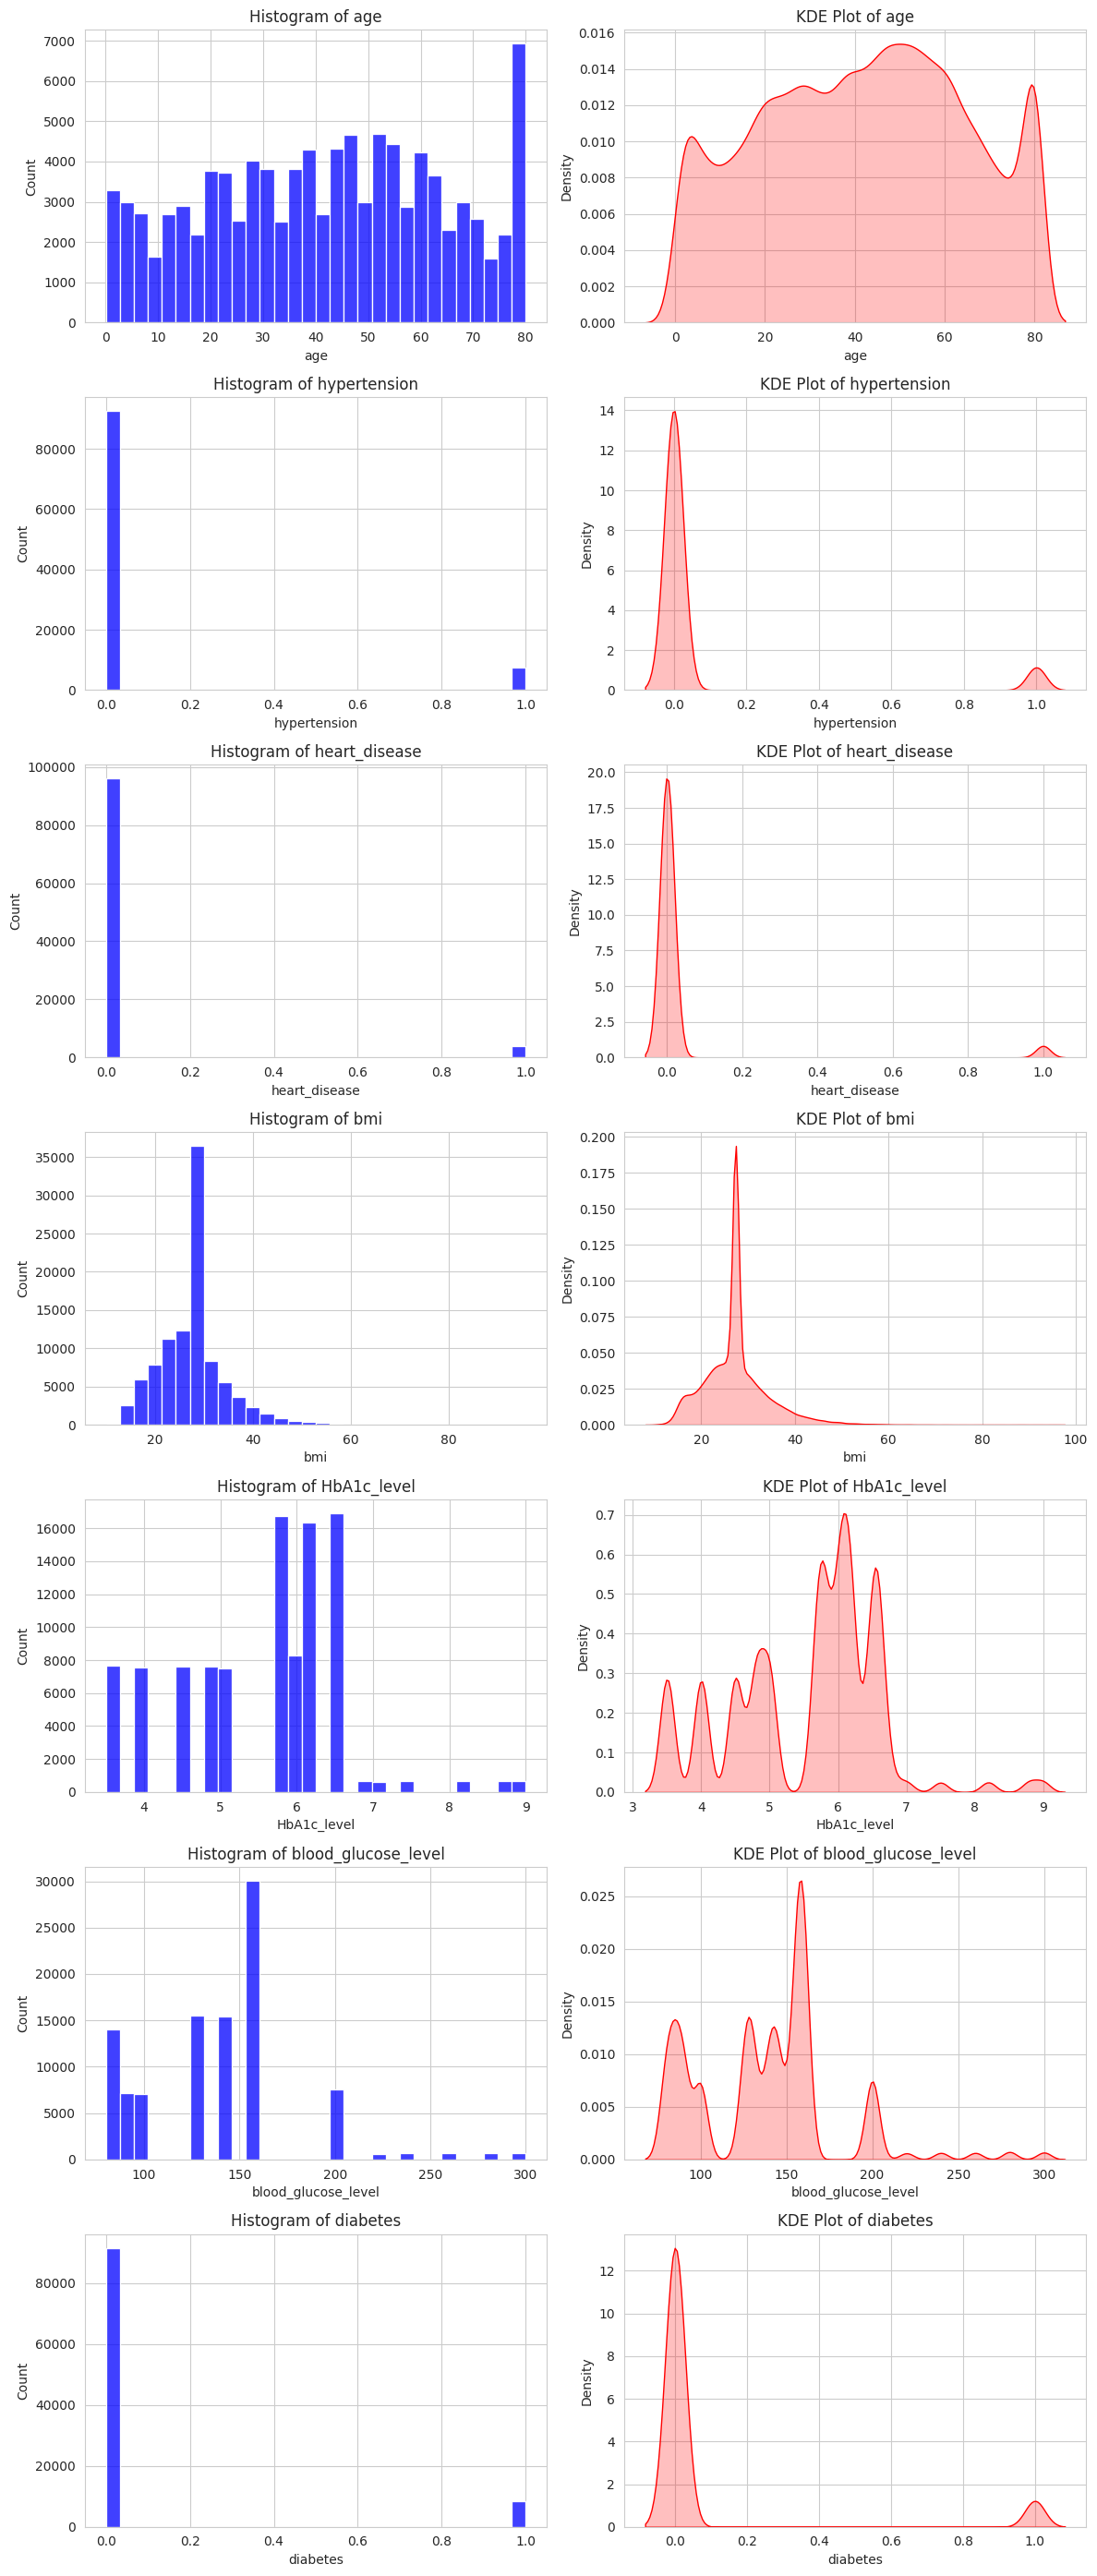

<ipython-input-18-4770ebfc2645>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], ax=axes[i], palette="coolwarm")
<ipython-input-18-4770ebfc2645>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
<ipython-input-18-4770ebfc2645>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], ax=axes[i], palette="coolwarm")
<ipython-input-18-4770ebfc2645>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(

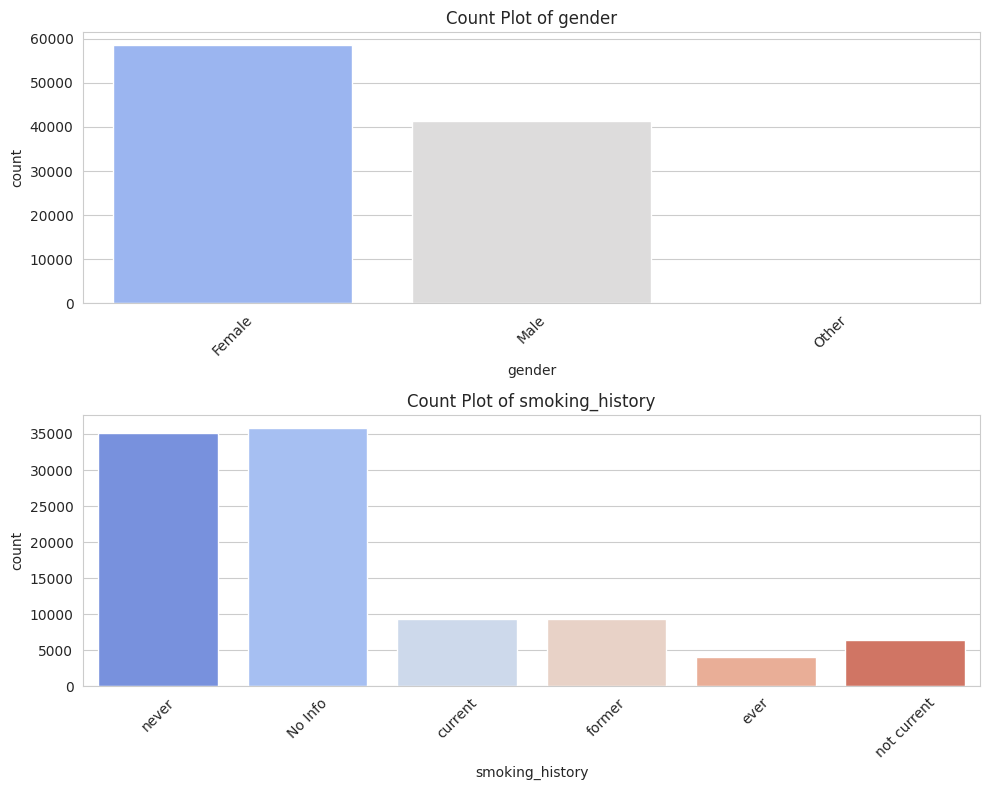

In [18]:
# Set plot style
sns.set_style("whitegrid")

# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Plot numerical columns
fig, axes = plt.subplots(nrows=len(num_cols), ncols=2, figsize=(12, 4 * len(num_cols)))

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30, kde=False, ax=axes[i, 0], color="blue")
    axes[i, 0].set_title(f"Histogram of {col}")

    sns.kdeplot(df[col], ax=axes[i, 1], fill=True, color="red")
    axes[i, 1].set_title(f"KDE Plot of {col}")

plt.tight_layout()
plt.show()

# Plot categorical columns (bar plots)
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(10, 4 * len(cat_cols)))

for i, col in enumerate(cat_cols):
    sns.countplot(x=df[col], ax=axes[i], palette="coolwarm")
    axes[i].set_title(f"Count Plot of {col}")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


## **Feature Selection and Engineering**

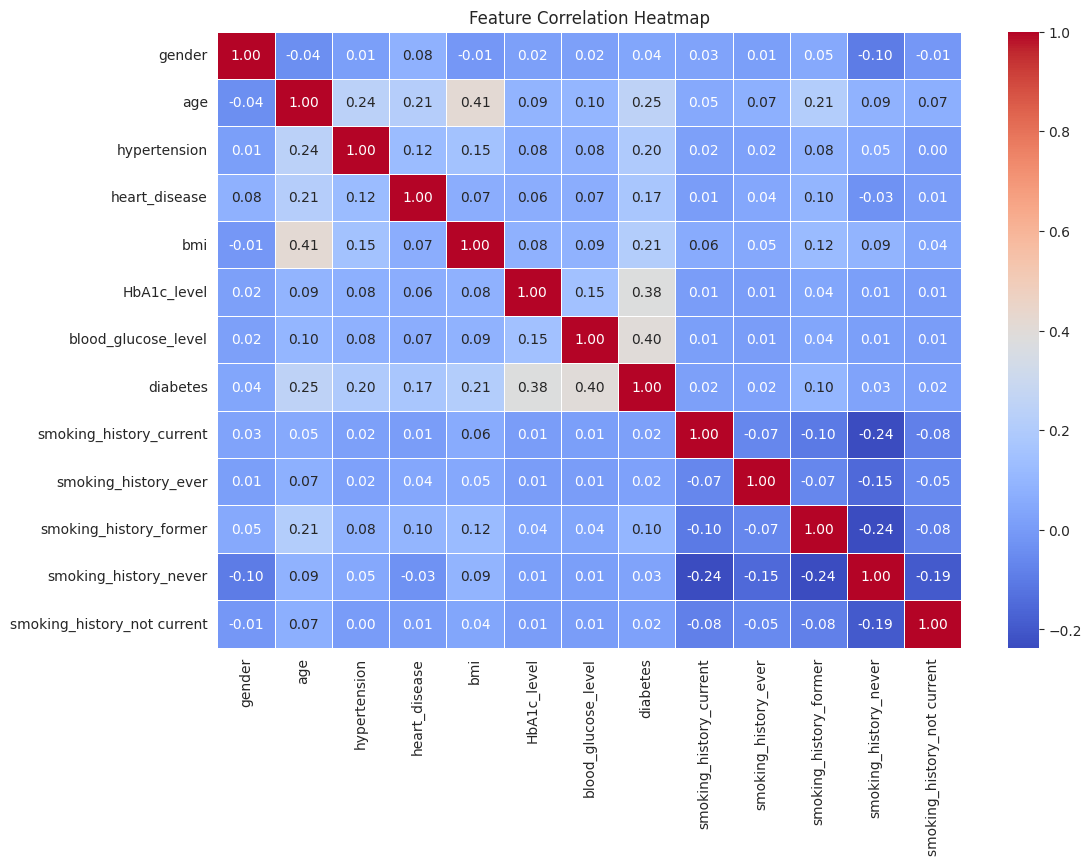

In [19]:

# Feature Selection Using Correlation
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Remove highly correlated features
correlation_matrix = df_encoded.corr()
high_corr_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:
            high_corr_features.add(correlation_matrix.columns[i])

df_encoded.drop(columns=high_corr_features, inplace=True)


## **Feature Importance**

<ipython-input-20-33d904288357>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importances, palette="viridis")


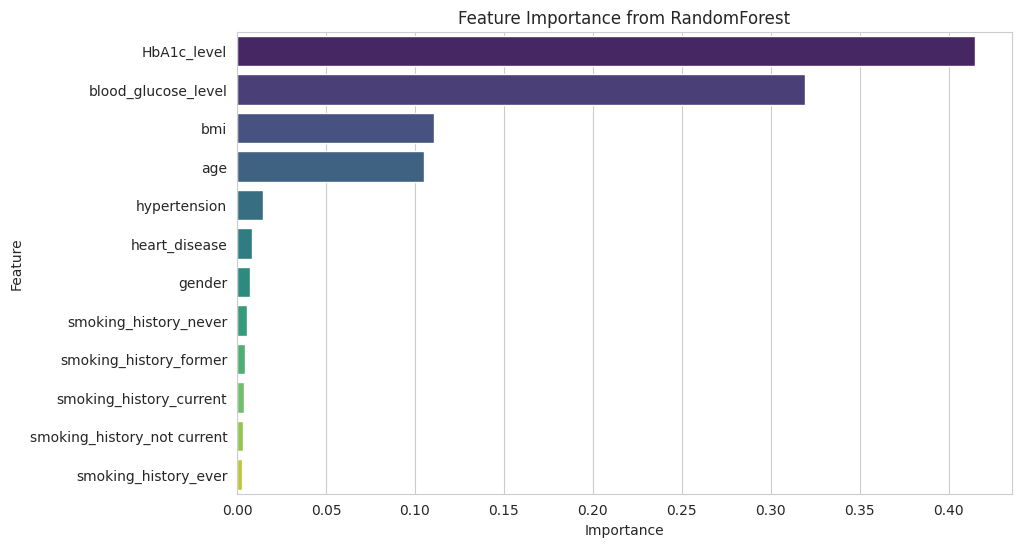

In [20]:

# Feature Importance using RandomForest
X = df_encoded.drop(columns=["diabetes"])
y = df_encoded["diabetes"]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_})
importances = importances.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importances, palette="viridis")
plt.title("Feature Importance from RandomForest")
plt.show()


In [21]:

# Select Important Features Using New DataFrame df_impo
selector = SelectFromModel(rf, threshold="mean", prefit=True)
selected_features = X.columns[(selector.get_support())]
print(f"Selected Features: {list(selected_features)}")

# Create new DataFrame df_impo to keep only selected features
df_impo = df_encoded[selected_features.to_list() + ["diabetes"]]


Selected Features: ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']


## **Train-Test Splitting and Class Balancing**

In [22]:

# Train-Test Split
X = df_impo.drop(columns=['diabetes'])
y = df_impo['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Class distribution in training set:\n", y_train.value_counts(normalize=True))
print("Class distribution in testing set:\n", y_test.value_counts(normalize=True))


Class distribution in training set:
 diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64
Class distribution in testing set:
 diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


In [23]:
# Handle Class Imbalance Using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:\n", y_train_resampled.value_counts(normalize=True))
print("X_test shape:", X_test.shape)
print("X_train shape (after SMOTE):", X_train_resampled.shape)


Class distribution after SMOTE:
 diabetes
1    0.5
0    0.5
Name: proportion, dtype: float64
X_test shape: (20000, 4)
X_train shape (after SMOTE): (146400, 4)


## **Checking for Data Leakage**

In [24]:

# Check for Data Leakage (Duplicates in Train-Test Split)
duplicates_between_train_test = X_train_resampled.merge(X_test, how='inner')

if len(duplicates_between_train_test) > 0:
    print(f"⚠ Warning: {len(duplicates_between_train_test)} duplicate records found!")
    X_train_resampled = X_train_resampled.drop(duplicates_between_train_test.index)
    y_train_resampled = y_train_resampled.loc[X_train_resampled.index]
    print(f"✅ Fixed: Training set now has {X_train_resampled.shape[0]} samples.")
else:
    print("✅ No duplicate records found between training and test sets.")


⚠ Warning: 12389 duplicate records found!
✅ Fixed: Training set now has 134011 samples.


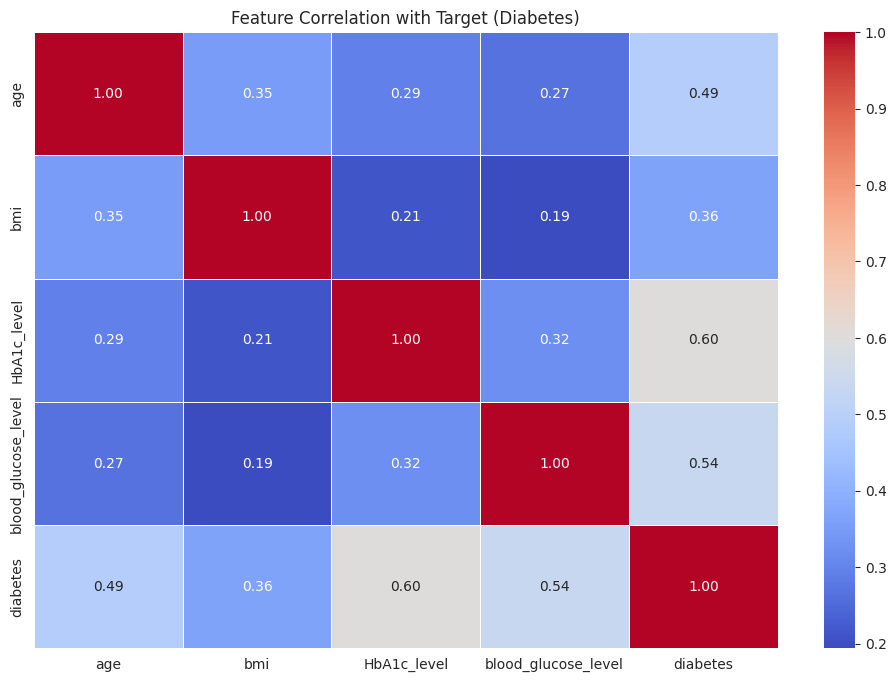

In [25]:

# Check Feature Correlation with Target After Cleaning
df_corr_check = pd.concat([X_train_resampled, y_train_resampled], axis=1)
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr_check.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation with Target (Diabetes)")
plt.show()